In [ ]:
!pip install timm # Installing timm, a computer vision library for pytorch
# # Downloading a swin IR Model.
# # More models can be found here: https://github.com/JingyunLiang/SwinIR/releases/
# # !wget -O swin-ir.pth https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/001_classicalSR_DF2K_s64w8_SwinIR-M_x2.pth # these weights.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import timm
import numpy as np
import cv2
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sys, os
import math
import tensorflow as tf
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# import skimage

2024-04-17 03:23:07.701615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 03:23:07.701716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 03:23:07.889893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Model init

In [ ]:
# def model():
#     SRCNN = tf.keras.Sequential(name='SRCNN')
#     SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9),
#                                      padding='VALID',
#                                      use_bias=True,
#                                      input_shape=(32, 32, 3),
#                                      kernel_initializer='glorot_uniform',
#                                      activation='relu'))
#     SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
#                                      padding='SAME',
#                                      use_bias=True,
#                                      kernel_initializer='glorot_uniform',
#                                      activation='relu'))
#     SRCNN.add(tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5),
#                                      padding='VALID',
#                                      use_bias=True,
#                                      kernel_initializer='glorot_uniform',
#                                      activation='relu'))  # Note: Using ReLU activation here

#     # Upsample the output to match the desired output size (64, 64)
#     SRCNN.add(tf.keras.layers.UpSampling2D(size=(3, 3)))  # Upsample by a factor of 2
#     SRCNN.add(tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3),
#                                      padding='SAME',
#                                      use_bias=True,
#                                      kernel_initializer='glorot_uniform',
#                                      activation='linear'))  # Linear activation for RGB values

#     # Optimizer
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

#     # Compile model
#     SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

#     return SRCNN

In [ ]:
import torch.nn as nn
import math
import torch
import torch.nn.functional as F
from torch.autograd import Variable

def make_model(args, parent=False):
    return RCAN(args)


class MeanShift(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1)
        self.weight.data.div_(std.view(3, 1, 1, 1))
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

## Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size, reduction,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0: modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        #res = self.body(x).mul(self.res_scale)
        res += x
        return res

## Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, act, res_scale, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = []
        modules_body = [
            RCAB(
                conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1) \
            for _ in range(n_resblocks)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

## Residual Channel Attention Network (RCAN)
class RCAN(nn.Module):
    def __init__(self, args, conv=default_conv):
        super(RCAN, self).__init__()

        n_resgroups = args.n_resgroups
        n_resblocks = args.n_resblocks
        n_feats = args.n_feats
        kernel_size = 3
        reduction = args.reduction
        scale = args.scale[0]
        act = nn.ReLU(True)

        # RGB mean for DIV2K
        rgb_mean = (0.4488, 0.4371, 0.4040)
        rgb_std = (1.0, 1.0, 1.0)
        self.sub_mean = MeanShift(args.rgb_range, rgb_mean, rgb_std)

        # define head module
        modules_head = [conv(args.n_colors, n_feats, kernel_size)]

        # define body module
        modules_body = [
            ResidualGroup(
                conv, n_feats, kernel_size, reduction, act=act, res_scale=args.res_scale, n_resblocks=n_resblocks) \
            for _ in range(n_resgroups)]

        modules_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        modules_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, args.n_colors, kernel_size)]

        self.add_mean = MeanShift(args.rgb_range, rgb_mean, rgb_std, 1)

        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        x = self.sub_mean(x)
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        x = self.add_mean(x)

        return x

    def load_state_dict(self, state_dict, strict=False):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') >= 0:
                        print('Replace pre-trained upsampler to new one...')
                    else:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))

        if strict:
            missing = set(own_state.keys()) - set(state_dict.keys())
            if len(missing) > 0:
                raise KeyError('missing keys in state_dict: "{}"'.format(missing))

In [ ]:
class Args:
    def __init__(self):
        self.n_resgroups = 10
        self.n_resblocks = 20
        self.n_feats = 64
        self.reduction = 16
        self.scale = [2]
        self.res_scale = 1
        self.n_colors = 3
        self.rgb_range = 1
args = Args()
rcan_model = make_model(args)
rcan_model = rcan_model.to(device)
# rcan_model

In [ ]:
# srcnn_model = model()
# srcnn_model.summary()

# training


In [ ]:

def set_random_seed(seed_value):

    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

    np.random.seed(seed_value)

# Set a specific seed value
seed_value = 83
set_random_seed(seed_value)

In [ ]:
# srcnn_model.train()
# print("Model is in training mode")

In [ ]:
# from google.colab import drive

# # Mount the drive at the default location (/content/gdrive)
# drive.mount('/content/gdrive')

In [ ]:
# !ls

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import os


class Sharpen(object):
    def __init__(self, strength):
        self.strength = strength

    def __call__(self, img):
        img_np = np.array(img)
        blurred = cv2.GaussianBlur(img_np, (0, 0), 1.0)
        sharpened = cv2.addWeighted(img_np, 1.0 + self.strength, blurred, -self.strength, 0)
        return sharpened

# Replace 'path/to/your/dataset' with the actual path
dataset_root = '/kaggle/input/img-data/Set14/Set14'

# Define transformations for your images (e.g., resize, normalize)
transform_L = transforms.Compose([
    transforms.Resize((32,32)),  # Resize images to 256x256 (adjust as needed)
    transforms.ToTensor(),  # Convert images to tensors
#     transforms.Lambda(lambda x: Sharpen(0.5)(x)),
])

transform_L_Sh = transforms.Compose([
    transforms.Resize((32,32)),  # Resize images to 256x256 (adjust as needed)
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Lambda(lambda x: Sharpen(0.5)(x)),
])

transform_H = transforms.Compose([
    transforms.Resize((64,64)),  # Resize images to 256x256 (adjust as needed)
    transforms.ToTensor(),  # Convert images to tensors
])

# Create separate ImageFolder instances for data and label folders
data_path = os.path.join(dataset_root, "X")
label_path = os.path.join(dataset_root, "y")

data_dataset = ImageFolder(root=data_path, transform=transform_L)
data_dataset_Sh = ImageFolder(root=data_path, transform=transform_L_Sh)
label_dataset = ImageFolder(root=label_path, transform=transform_H)

# Combine data and labels into a single dataset (optional)
# This assumes data and label images have the same order based on filename
combined_dataset = []
combined_dataset_Sh = []
# for data, _ in data_dataset:
#   for label, _ in label_dataset:
#     combined_dataset.append((data, label))

for i in range(0, len(data_dataset)):
    combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))

for i in range(0, len(data_dataset_Sh)):
    combined_dataset_Sh.append((data_dataset_Sh[i][0], label_dataset[i][0]))

# for i in range(0, 1):
#     combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))

# Create dataloader (choose between separate or combined datasets)
# Option 1: Separate dataloaders for data and labels
data_loader = DataLoader(data_dataset, batch_size=1, shuffle=False)
data_loader_Sh = DataLoader(data_dataset_Sh, batch_size=1, shuffle=False)
label_loader = DataLoader(label_dataset, batch_size=1, shuffle=False)

# Option 2: Dataloader for combined dataset
train_loader = DataLoader(combined_dataset, batch_size=7, shuffle=False)
train_loader_Sh = DataLoader(combined_dataset_Sh, batch_size=7, shuffle=False)

# Choose the appropriate dataloader(s) based on your training needs


In [ ]:
data, label = next(iter(train_loader))
data2, _ = next(iter(train_loader_Sh))
print(f"Data shape: {data2.shape}")
print(f"Label shape: {label.shape}")

Data shape: torch.Size([7, 3, 32, 32])
Label shape: torch.Size([7, 3, 64, 64])


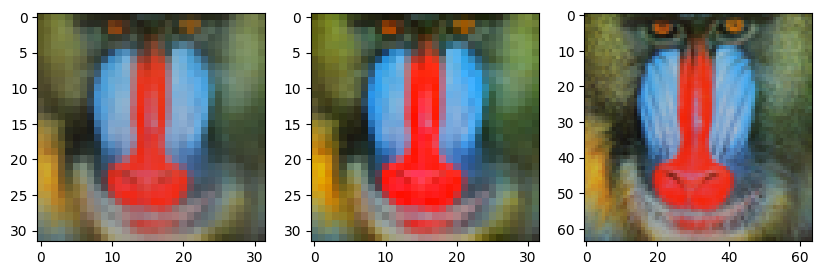

In [ ]:
import matplotlib.pyplot as plt

# Display the first image in the batch
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(data[0].permute(1, 2, 0))
plt.subplot(1,3,2)
plt.imshow(data2[0].permute(1, 2, 0))
plt.subplot(1,3,3)
plt.imshow(label[0].permute(1, 2, 0))
plt.show()


In [ ]:
from torch.nn.parallel import DataParallel
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     if torch.cuda.device_count() > 1:
#         print("Using", torch.cuda.device_count(), "GPUs!")
#     else:
#         print("Using single GPU")
# else:
#     device = torch.device("cpu")
#     print("CUDA is not available, using CPU.")

# rcan_model = DataParallel(rcan_model)
# rcan_model = rcan_model.to(device)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Assuming train_loader is your DataLoader instance

# Define the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the training parameters
lr = 0.0001
batch_size = 7
epochs = 1000

# Define the optimizer and loss function
optimizer = optim.Adam(rcan_model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Assuming train_loader is your DataLoader instance
n_total_steps = len(train_loader)

for epoch in range(epochs):
    # Train the model
    for batch, (images, labels) in enumerate(train_loader):
        # Move input data to the device
        images = images.to(0)
        labels = labels.to(0)

        # Forward pass
        outputs = rcan_model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{batch+1}/{n_total_steps}], Loss: {loss.item()}')


Epoch [100/1000], Step [1/2], Loss: 0.0038739535957574844
Epoch [100/1000], Step [2/2], Loss: 0.0039409371092915535
Epoch [200/1000], Step [1/2], Loss: 0.0024711887817829847
Epoch [200/1000], Step [2/2], Loss: 0.0026111591141670942
Epoch [300/1000], Step [1/2], Loss: 0.001590105821378529
Epoch [300/1000], Step [2/2], Loss: 0.0017702995100989938
Epoch [400/1000], Step [1/2], Loss: 0.001106054289266467
Epoch [400/1000], Step [2/2], Loss: 0.0010971928713843226
Epoch [500/1000], Step [1/2], Loss: 0.0007319840369746089
Epoch [500/1000], Step [2/2], Loss: 0.0007529239519499242
Epoch [600/1000], Step [1/2], Loss: 0.0005891204345971346
Epoch [600/1000], Step [2/2], Loss: 0.00056753697572276
Epoch [700/1000], Step [1/2], Loss: 0.00039932242361828685
Epoch [700/1000], Step [2/2], Loss: 0.00041132181650027633
Epoch [800/1000], Step [1/2], Loss: 0.0003051644016522914
Epoch [800/1000], Step [2/2], Loss: 0.0002990132779814303
Epoch [900/1000], Step [1/2], Loss: 0.00023998590768314898
Epoch [900/1000

In [ ]:
# # Define a function to convert PyTorch tensor to TensorFlow tensor
# def torch_to_tf(tensor):
#     return tf.convert_to_tensor(tensor.numpy())

# num_epochs = 200

# for epoch in range(1, num_epochs+1):
#     total_loss = 0
#     total_accuracy = 0

#     for data, label in train_loader:
#         # Transpose data to match expected input shape (32, 32, 3)
#         data = data.permute(0, 2, 3, 1)  # This will change the shape from (1, 3, 32, 32) to (1, 32, 32, 3)
#         label = label.permute(0, 2, 3, 1)

#         # Convert data and label to NumPy arrays and then to TensorFlow tensors
#         data_tf = torch_to_tf(data)
#         label_tf = torch_to_tf(label)

#         # Train the model on the batch
#         loss, accuracy = srcnn_model.train_on_batch(data_tf, label_tf)

#         total_loss += loss

#     # Print loss and accuracy every 10 epochs
#     if epoch % 10 == 0:
#         average_loss = total_loss / len(train_loader)
#         print(f"Epoch {epoch}, Loss: {average_loss}")

In [ ]:
# print(len(train_loader.dataset))
# print(train_loader.dataset[0])

In [ ]:
# # prompt: Train the model

# # Define loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(srcnn_model.parameters(), lr=0.001)

# # Training loop
# epochs = 200
# for epoch in range(epochs):
#   for i, (data, label) in enumerate(train_loader):
#     # Move data to device
#     data = data.to(device)
#     label = label.to(device)

#     # Forward pass
#     output = srcnn_model(data)

#     # Calculate loss
#     h, w = output.shape[2], output.shape[3]
#     # print(h, w)
#     transform_resize = transforms.Resize((h, w))
#     changed_label = transform_resize(label)
#     loss = criterion(output, changed_label)

#     # Backpropagation
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Print training progress
#     if (epoch%100 == 0):
#       print(f"Epoch: {epoch + 1}/{epochs}, Batch: {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")

# # Save the trained model
# torch.save(model.state_dict(), "trained_model.pth")


# testing

In [ ]:
# model = model.eval()

In [ ]:
# !wget -O butterfly.png https://raw.githubusercontent.com/JingyunLiang/SwinIR/main/testsets/RealSRSet%2B5images/butterfly.png

In [ ]:
# test_data, test_label = next(iter(train_loader))

In [ ]:
# test_img = test_data
# plt.figure(figsize=(3,3))
# plt.imshow(test_img[0].permute(1, 2, 0))
# plt.show()

In [ ]:
# img_lq = test_img[0].permute(1, 2, 0).clamp(0,1).numpy().astype(np.float32)
# img_lq = np.transpose(img_lq if img_lq.shape[2] == 1 else img_lq[:, :, [2, 1, 0]], (2, 0, 1))  # HCW-BGR to CHW-RGB
# img_lq = torch.from_numpy(img_lq).float().unsqueeze(0).to("cuda") # add .to() if u have cuda

# img_lq = test_img

In [ ]:

# print(img_lq.shape)

In [ ]:
# window_size = 8
# SCALE = 2
# with torch.no_grad():
#   # pad input image to be a multiple of window_size
#   _, _, h_old, w_old = img_lq.size()
#   h_pad = (h_old // window_size + 1) * window_size - h_old
#   w_pad = (w_old // window_size + 1) * window_size - w_old
#   img_lq = torch.cat([img_lq, torch.flip(img_lq, [2])], 2)[:, :, :h_old + h_pad, :]
#   img_lq = torch.cat([img_lq, torch.flip(img_lq, [3])], 3)[:, :, :, :w_old + w_pad]
#   print(img_lq.shape)
#   output = model(img_lq.to(device))
#   output = output[..., :h_old * SCALE, :w_old * SCALE]

# with torch.no_grad():
#   output = model(img_lq.to(device))


In [ ]:
# output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
# output = (output * 255.0).round().astype(np.uint8)

In [ ]:
# plt.imshow(output.transpose(1,2,0))
# plt.show()

In [ ]:
# data, label = next(iter(train_loader))
# data = data.permute(0, 2, 3, 1)  # This will change the shape from (1, 3, 32, 32) to (1, 32, 32, 3)
# label = label.permute(0, 2, 3, 1)

# # Convert data and label to NumPy arrays and then to TensorFlow tensors
# data_tf = torch_to_tf(data)
# label_tf = torch_to_tf(label)

# output = srcnn_model.predict(data_tf)
# # output = np.clip(output, 0, 1)*255

# # Display the input data, output, and label
# plt.figure(figsize=(12, 4))

# for i in range(5):
#     plt.subplot(1, 3, 1)
#     plt.imshow(data[i])
#     plt.title('Input Data')
#     plt.axis('off')

#     plt.subplot(1, 3, 2)
#     plt.imshow(output[i])
#     plt.title('Output')
#     plt.axis('off')

#     plt.subplot(1, 3, 3)
#     plt.imshow(label[i])
#     plt.title('Ground Truth Label')
#     plt.axis('off')

#     plt.show()

In [ ]:
def psnr(img1, img2):
    # Convert images to PyTorch tensors
    img1_tensor = torch.tensor(img1, dtype=torch.float32)
    img2_tensor = torch.tensor(img2, dtype=torch.float32)

    # Compute Mean Squared Error (MSE)
    mse = F.mse_loss(img1_tensor, img2_tensor)

    # Compute PSNR in decibels (dB)
    max_pixel_value = 1.0  # Assuming images are in the range [0, 255]
    psnr_db = 10 * torch.log10((max_pixel_value ** 2) / mse)

    return psnr_db.item()  # Return PSNR value in dB as a Python float

/tmp/ipykernel_34/892943651.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1_tensor = torch.tensor(img1, dtype=torch.float32)


psnr between model output and ideal output = 37.493167877197266


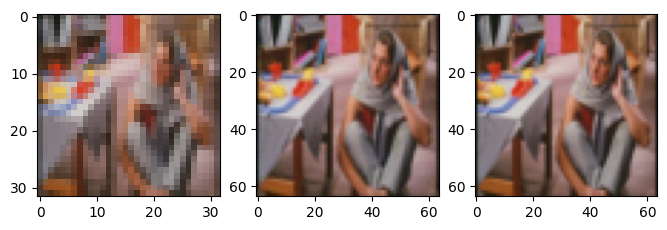

psnr between model output and ideal output = 37.76325988769531


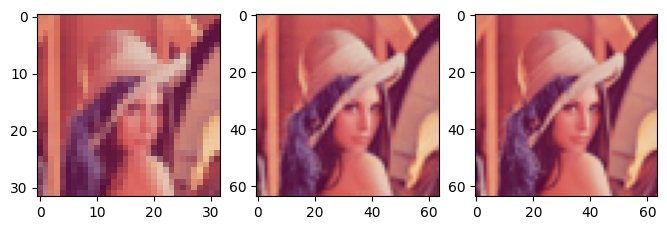

In [ ]:
# Loop over the train_loader
for img, label in train_loader:
    # Move input data to the device
    img = img.to(0)
    label = label.to(0)

    # Perform inference with no gradient calculation
    with torch.no_grad():
        output = rcan_model(img)

    # Move output back to the CPU for visualization
#     output = output.cpu()
#     img = img.cpu()
#     label = label.cpu()
    output = output.data.float().cpu().clamp_(0, 1).numpy()
    output = (output * 255.0).round().astype(np.uint8)
    plt.figure(figsize=(8, 8))
    plt.subplot(1,3,1)
    plt.imshow(img[1].cpu().permute(1, 2, 0))
    plt.subplot(1, 3, 2)
    plt.imshow(output[1].transpose(1, 2, 0)/255)
    plt.subplot(1, 3, 3)
    plt.imshow(label[1].cpu().permute(1, 2, 0))
    print(f"psnr between model output and ideal output = {psnr(label[1].cpu().permute(1, 2, 0), output[1].transpose(1, 2, 0)/255)}")

    plt.show()

#     # Visualize some samples
#     for i in range(1):

#         # Convert tensors to numpy arrays
#         output_np = output[i].permute(1, 2, 0).numpy()
#         label_np = label[i].permute(1, 2, 0).numpy()

# #         print(output_np, label_np)

#         # Calculate PSNR using cv2.PSNR
#         psnr = cv2.PSNR(output_np, label_np)

#         print(f"PSNR of output[{i}] compared to label[{i}]: {psnr:.2f} dB")

#         plt.figure(figsize=(8, 8))
#         plt.subplot(1,3,1)
#         plt.imshow(img[i].permute(1, 2, 0).numpy())
#         plt.subplot(1, 3, 2)
#         plt.imshow(output[i].permute(1, 2, 0).numpy())
#         plt.subplot(1, 3, 3)
#         plt.imshow(label[i].permute(1, 2, 0).numpy())
#         plt.show()

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import os

# Replace 'path/to/your/dataset' with the actual path
def makeTestLoader():
  dataset_root = '/kaggle/input/img-data/Set5/Set5'

  # Define transformations for your images (e.g., resize, normalize)
  transform_L = transforms.Compose([
      transforms.Resize((32,32)),  # Resize images to 256x256 (adjust as needed)
      transforms.ToTensor(),  # Convert images to tensors
      # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
  ])

  transform_H = transforms.Compose([
      transforms.Resize((64,64)),  # Resize images to 256x256 (adjust as needed)
      transforms.ToTensor(),  # Convert images to tensors
      # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
  ])

  # Create separate ImageFolder instances for data and label folders
  data_path = os.path.join(dataset_root, "X")
  label_path = os.path.join(dataset_root, "y")

  data_dataset = ImageFolder(root=data_path, transform=transform_L)
  label_dataset = ImageFolder(root=label_path, transform=transform_H)

  combined_dataset = []

  for i in range(0, len(data_dataset)):
      combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))

  data_loader = DataLoader(data_dataset, batch_size=1, shuffle=False)
  label_loader = DataLoader(label_dataset, batch_size=1, shuffle=False)

  test_loader = DataLoader(combined_dataset, batch_size=5, shuffle=False)
  return test_loader


In [ ]:
test_loader = makeTestLoader()

In [ ]:
# for img, label in test_loader:
# #   img = img.permute(0, 2, 3, 1)
# #   label = label.permute(0, 2, 3, 1)

# #   img_tf =torch_to_tf(img)
# #   label_tf = torch_to_tf(label)

#   output = rcan_model(img_tf)

#   # Display the input data, output, and label
#   plt.figure(figsize=(12, 4))

#  for i in range(7):
#     plt.figure(figsize=(8, 8))
#     plt.subplot(1,3,1)
#     plt.imshow(img[i].permute(1, 2, 0))
#     plt.subplot(1, 3, 2)
#     plt.imshow(output[i].permute(1, 2, 0))
#     plt.subplot(1, 3, 3)
#     plt.imshow(label[i].permute(1, 2, 0))
#     plt.show()





/tmp/ipykernel_34/892943651.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1_tensor = torch.tensor(img1, dtype=torch.float32)


psnr between model output and ideal output = 21.652345657348633


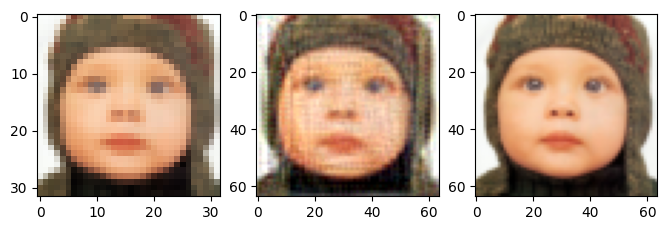

In [ ]:
# # Loop over the train_loader
# for img, label in test_loader:
#     # Move input data to the device
#     img = img.to(device)
#     label = label.to(device)

#     # Perform inference with no gradient calculation
#     with torch.no_grad():
#         output = rcan_model(img)

#     # Move output back to the CPU for visualization
#     output = output.cpu()
#     img = img.cpu()
#     label = label.cpu()

#     # Print output shape
#     print(output.shape)

#     # Visualize some samples
#     for i in range(5):
#         # Convert tensors to numpy arrays
#         output_np = output[i].permute(1, 2, 0).numpy()
#         label_np = label[i].permute(1, 2, 0).numpy()

#         print(output_np.shape, label_np.shape)

#         # Calculate PSNR using cv2.PSNR
#         psnr = cv2.PSNR(output_np, label_np)

#         print(f"PSNR of output[{i}] compared to label[{i}]: {psnr:.2f} dB")

#         plt.figure(figsize=(8, 8))
#         plt.subplot(1,3,1)
#         plt.imshow(img[i].permute(1, 2, 0).numpy())
#         plt.subplot(1, 3, 2)
#         plt.imshow(output[i].permute(1, 2, 0).numpy())
#         plt.subplot(1, 3, 3)
#         plt.imshow(label[i].permute(1, 2, 0).numpy())
#         plt.show()

# Loop over the train_loader
for img, label in test_loader:
    # Move input data to the device
    img = img.to(0)
    label = label.to(0)

    # Perform inference with no gradient calculation
    with torch.no_grad():
        output = rcan_model(img)

    # Move output back to the CPU for visualization
#     output = output.cpu()
#     img = img.cpu()
#     label = label.cpu()
    output = output.data.float().cpu().clamp_(0, 1).numpy()
    output = (output * 255.0).round().astype(np.uint8)
    plt.figure(figsize=(8, 8))
    plt.subplot(1,3,1)
    plt.imshow(img[0].cpu().permute(1, 2, 0))
    plt.subplot(1, 3, 2)
    plt.imshow(output[0].transpose(1, 2, 0)/255)
    plt.subplot(1, 3, 3)
    plt.imshow(label[0].cpu().permute(1, 2, 0))
    print(f"psnr between model output and ideal output = {psnr(label[0].cpu().permute(1, 2, 0), output[0].transpose(1, 2, 0)/255)}")

    plt.show()